# **基于PalldeClas实现线上监考**
# **一、项目简介**
	  疫情之后，线上考试的需求剧增，由此而来的线上监考的所需花费的人力和物力也不断增加。本项目基于2020年东华大学线上考试收集的监考画面，使用paddleclda实现自动监考


# **二、PaddleClas介绍**

	  众所周知，PaddleClas是飞桨研发专门针对实现图像分类的套件，PaddleClas中包括了多达23个系列的模型结构、ImageNet1k验证集精度82.4%的ResNet50_vd模型、10W类的图像分类预训练模型，同时提供了知识蒸馏以及丰富的数据增广方案，帮助图像分类模型进一步获得性能提升。
## 图像分类任务简介
      图像分类是根据图像的语义信息将不同类别图像区分开来，是计算机视觉中重要的基础任务。
      图像分类在很多领域有广泛应用，包括零售商品分类、农作物品质分级、医学领域的图像识别、交通标志分类等。作为计算机视觉任务的基础，还可辅助目标检测、图像分割、物体跟踪、行为分析等其他高层视觉任务组网和效果提升，比如经典的目标检测模型FasterRCNN的结构，骨干网络即使用分类任务中的网络结构，如ResNet。作为骨干网络，分类任务的预训练模型也可以帮助其他视觉任务在训练时更快地收敛。
如果有想更详细了解的小伙伴可以戳下方链接慢慢了解：
 
[PaddleClas github地址：](https://github.com/PaddlePaddle/PaddleClas/)

<https://github.com/PaddlePaddle/PaddleClas/>

[PaddleClas教程文档地址：](https://paddleclas.readthedocs.io/zh_CN/latest/index.html)

<https://paddleclas.readthedocs.io/zh_CN/latest/index.html>

## 解压PaddleClas
	PaddleClas需要大家从github上clone下载，速度有时会比较慢，这里已经为大家准备好了，放在data目录下，大家自己解压使用就好，如果有想克隆的小伙伴可以自己克隆，代码如下：git clone https://github.com/PaddlePaddle/PaddleClas.git

In [ ]:
!unzip -oq data/data114890/PaddleClas.zip -d /home/aistudio/

^C


# **三、数据集介绍**
	本项目用的是大学生线上考试监考监控数据集，一共有六类，分别是：qualifIed、more_than_one_people、uncorrelated、using_phone、without_computer、without_examinee、wrong_angel共有500+张图片，图片数量比较多，加载时间比较长，请小伙伴们耐心等待
* 需要注意的是：
    * 数据集存放路径要与配置文件中一直，不要忘记修改
    * 数据列表文件中路径与标签之间的空格要划分准确
    * 数据列表文件中不要包含其他文件

## 解压数据集
	数据集已经给大家放在PaddleClas/dataset目录下，因为之后在训练过程中放在dataset下面会比较方便训练，所以这边直接给大家放好了

In [ ]:
!unzip -oq data/data128035/dataset.zip
!mv dataset PaddleClas/dataset

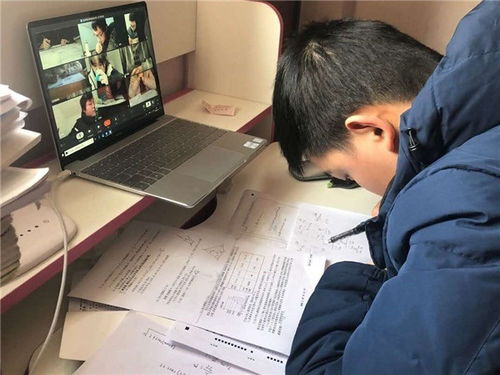

In [2]:
from PIL import Image

# 读取图片
png_img = Image.open('PaddleClas/dataset/dataset/qualified/18.jpg')
png_img  # 展示图片

# **四、 数据处理**
	大家不难发现，数据集的格式是每类图片集的文件名就是图片的lable，而且为了模拟真实的情况，所有的文件都没有标注，需要我们进行数据集和验证集的划分
* 需要注意的是：
    * 数据集存放的位置与生成的数据列表文件中的数据路径需要与配置文件对应，这也是初学者时常出现问题的地方。
    * 数据列表文件中路径与标签之间的分割符号，行与行之间的换行符号
    * 有些特定字符转义之后出现问题

In [4]:
#划分数据集
import codecs
import os
import random
import shutil
from PIL import Image

train_ratio = 4.0 / 5
#all_file_dir = 'PaddleClas/dataset/fer62013'
all_file_dir = 'PaddleClas/dataset/dataset'
class_list = [c for c in os.listdir(all_file_dir) if os.path.isdir(os.path.join(all_file_dir, c)) and not c.endswith('Set') and not c.startswith('.')]
class_list.sort()
print(class_list)
train_image_dir = os.path.join(all_file_dir, "trainImageSet")
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
    
eval_image_dir = os.path.join(all_file_dir, "evalImageSet")
if not os.path.exists(eval_image_dir):
    os.makedirs(eval_image_dir)

train_file = codecs.open(os.path.join(all_file_dir, "train.txt"), 'w')
eval_file = codecs.open(os.path.join(all_file_dir, "eval.txt"), 'w')

with codecs.open(os.path.join(all_file_dir, "label_list.txt"), "w") as label_list:
    label_id = 0
    for class_dir in class_list:
        label_list.write("{0}\t{1}\n".format(label_id, class_dir))
        image_path_pre = os.path.join(all_file_dir, class_dir)
        for file in os.listdir(image_path_pre):
            try:
                img = Image.open(os.path.join(image_path_pre, file))
                if random.uniform(0, 1) <= train_ratio:
                    shutil.copyfile(os.path.join(image_path_pre, file), os.path.join(train_image_dir, file))
                    train_file.write("{0} {1}\n".format(os.path.join("trainImageSet", file), label_id))
                else:
                    shutil.copyfile(os.path.join(image_path_pre, file), os.path.join(eval_image_dir, file))
                    eval_file.write("{0} {1}\n".format(os.path.join("evalImageSet", file), label_id))
            except Exception as e:
                pass
                # 存在一些文件打不开，此处需要稍作清洗
        label_id += 1
            
train_file.close()
eval_file.close()

['more_than_one_people', 'qualified', 'uncorrelated', 'using_phone', 'without_computer', 'without_examinee', 'wrong_angle']


## 查看划分的情况
	这里看到我们已经划分完整

In [5]:
!tree -d PaddleClas/dataset

PaddleClas/dataset
└── dataset
    ├── evalImageSet
    ├── more_than_one_people
    ├── qualified
    ├── trainImageSet
    ├── uncorrelated
    ├── using_phone
    ├── without_computer
    ├── without_examinee
    └── wrong_angle

10 directories


In [6]:
! head PaddleClas/dataset/dataset/train.txt

trainImageSet/26.jpg 0
trainImageSet/29.jpg 0
trainImageSet/1.jpg 0
trainImageSet/21.jpg 0
trainImageSet/34.jpg 0
trainImageSet/16.jpg 0
trainImageSet/118.jpg 0
trainImageSet/4.jpg 0
trainImageSet/13.jpg 0
trainImageSet/5.jpg 0


# **五、模型选择**

## **整体思路**
1. 选择使用的模型，根据自己的任务难度及数据的特点，选择适合自己数据的模型进行训练，**本文选择ResNet_vd模型训练**关于ResNet网络结构的代码分析可移步这里查看[ResNet网络结构代码分析](https://aistudio.baidu.com/aistudio/projectdetail/438756)
1. 根据选定的模型更改PaddleClas/configs下对应的配置文件参数。例如类别数，迭代次数，batch_size，数据集路径等等。为了查看方便本文将PaddleClas/configs/ResNet/ResNet50_vd.yaml移只根目录改名为neu.yaml，在训练时，修改配置文件的路径即可。
1. 利用更改后的配置文件训练模型，使用训练技巧与不同的参数设置调优模型并选择最优模型进行推理预测（更多的训练技巧与参数设置，可以关注 [https://paddleclas.readthedocs.io/zh_CN/latest/models/Tricks.html](https://paddleclas.readthedocs.io/zh_CN/latest/models/Tricks.html) 其对相关参数进行了详细的解释说明）
* 下面逐步说明各部分：

mix处理
 <div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/0392ea7c348c471d846b5a3112272cd35be448e18afb4becb3210f9472440683",width=900 >
</div>
数据处理

  <div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/06103e2b50a544d6a643179498fcefd26ae32ecf294a47118ce042b8ba7572bd",width=900>
</div>
配置文件的选择
  <div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/2388edf03bd049dba8bd13a9056439dd17cd588e11e94c749cca777aa432f4b8",width=900>
</div>
这里可以看到不同文件对应的效果的准确度也是不一样的，请大家从速度和精度两方面考虑
  <div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/992304f9838044ec9447d96e020a6a11ff82578198e1411ba84450f4cd104ac7",width=900 >
</div>
基础配置
  <div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/0f8f64581a5e4b4ca6025f38edac9f3743d3eedf1f17453ca504a9d2be862729",width=900>
</div>
学习率与优化器
 学习率

  <div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/ebaa63e298574c30a482bd3309d9bf3a3887fd68bc4645e4b0ee55ff08056615",width=900>
</div>
数据读取器与数据处理
  <div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/bbee689407cf4eccb7a4c691166fe5333dc34bbf54ba4bc38407916fbd251849",width=900>
</div>
优化器
  <div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/0236b7c4a50943568e5d2f98ba898e1d7393a150a6e248229e628ed59e7ffddb",width=900>
</div>

# **六、 训练模型**
训练模型分为一下几个步骤：
1. 修改配置文件。查看使用模型对应的配置文件并修改配置文件中一些必要的参数，本项目已经根据数据集适配了配置文件fer.yaml
1. 切换路径，设置环境变量
1. 训练模型

 **配置文件说明**
 
想必经过前面的介绍，大家已经能明白配置文件中各个参数的意思了，现在写一个新的配置文件为fer.yaml以及eval.yaml用作训练和评估的配置文件

**基础配置**

```
mode: "train"  运行模式 2中选择["train"," valid"]
ARCHITECTURE: 模型结构名字
    name: 'ResNet50_vd'
pretrained_model: "" 预训练模型路径
model_save_dir: "./output/" 保存模型路径
classes_num: 6 分类数
total_images: 1800 总图片数
save_interval: 10 每隔多少个epoch保存模型
validate: True 是否在训练时进行评估
valid_interval: 10 每隔多少个epoch进行模型评估
epochs: 400 训练总epoch数
topk: 5 评估指标K值大小
image_shape: [3, 224, 224] 图片大小
use_mix: True 是否启用mixup
ls_epsilon: 0.1 label_smoothing epsilon值
```
**学习率与优化配置**
```
LEARNING_RATE:
    function: 'Cosine' decay方法名  ["Linear", "Cosine","Piecewise", "CosineWarmup"]         
    params: 初始学习率     大部分的神经网络选择的初始学习率为0.1，batch_size是256，所以根据实际的模型大小和显存情况，可以将学习率设置为0.1*k,batch_size设置为256*k              
        lr: 0.1   
*还可设置的参数
params:
	decayepochs	 piecewisedecay中衰减学习率的milestone
params:
	gamma	    piecewisedecay中gamma值	
params:
	warmupepoch	 warmup轮数	
parmas:
	steps	    lineardecay衰减steps数	
params:
	endlr	    lineardecayendlr值	

OPTIMIZER:
    function: 'Momentum' 优化器方法名 ["Momentum", "RmsProp"]
    params:
        momentum: 0.9 momentum值
    regularizer:
        function: 'L2' 正则化方法名	
        factor: 0.000070 正则化系数
```
**训练配置**
```
TRAIN:
    batch_size: 32 批大小
    num_workers: 4 数据读取器worker数量
    file_list: "./dataset/NEU-CLS/train.txt" train文件列表
    data_dir: "./dataset/NEU-CLS" train文件路径
    shuffle_seed: 0 用来进行shuffle的seed值
    transforms: 数据处理
        - DecodeImage:
            to_rgb: True 数据转RGB
            to_np: False 数据转numpy
            channel_first: False 按CHW排列的图片数据
        - RandCropImage: 随机裁剪
            size: 224
        - RandFlipImage: 随机翻转
            flip_code: 1
        - NormalizeImage:
            scale: 1./255. 归一化scale值
            mean: [0.485, 0.456, 0.406] 归一化均值
            std: [0.229, 0.224, 0.225] 归一化方差
            order: '' 归一化顺序
        - ToCHWImage: 调整为CHW
    mix:                       
        - MixupOperator:    
            alpha: 0.2      
*还可设置的参数
-CropImage	
	size:	裁剪大小
-ResizeImage	
	resize_short:	按短边调整大小
 ```   
**测试配置**
```
VALID:
    batch_size: 64
    num_workers: 4
    file_list: "./dataset/NEU-CLS/eval.txt"
    data_dir: "./dataset/NEU-CLS"
    shuffle_seed: 0
    transforms:
        - DecodeImage:
            to_rgb: True
            to_np: False
            channel_first: False
        - ResizeImage:
            resize_short: 256
        - CropImage:
            size: 224
        - NormalizeImage:
            scale: 1.0/255.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
        - ToCHWImage:
```


In [ ]:
%%writefile fer.yaml
mode: "train"
ARCHITECTURE:
    name: 'ResNet50_vd'

pretrained_model: ""
model_save_dir: "./output/"
classes_num: 6
total_images: 10000
save_interval: 10
validate: True
valid_interval: 10
epochs: 201
topk: 5
image_shape: [3, 224,224]

use_mix: True
ls_epsilon: 0.1

LEARNING_RATE:
    function: 'CosineWarmup'
    params:                   
        lr: 0.1
        warmupepoch : 201
     

OPTIMIZER:
    function: 'Momentum'
    params:
        momentum: 0.9
    regularizer:
        function: 'L2'
        factor: 0.000070
TRAIN:
    batch_size: 128
    num_workers: 4
    file_list: "./dataset/fer62013/train.txt"
    data_dir: "./dataset/fer62013"
    shuffle_seed: 0
    transforms:
        - DecodeImage:
            to_rgb: True
            to_np: False
            channel_first: False
        - RandCropImage:
            size: 224
        - RandFlipImage:
            flip_code: 1
        - NormalizeImage:
            scale: 1./255.
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
        - ToCHWImage:
    mix:                       
        - MixupOperator:    
            alpha: 0.2      

VALID:
    batch_size: 512
    num_workers: 4
    file_list: "./dataset/fer62013/eval.txt"
    data_dir: "./dataset/fer62013"
    shuffle_seed: 0
    transforms:
        - DecodeImage:
            to_rgb: True
            to_np: False
            channel_first: False
        - ResizeImage:
            resize_short: 256
        - CropImage:
            size: 224
        - NormalizeImage:
            scale: 1.0/255.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
        - ToCHWImage:

Overwriting fer.yaml


In [ ]:
%%writefile eval.yaml
mode: 'valid'
ARCHITECTURE:
    name: "ResNet50_vd"

pretrained_model: "./pretrained_model/ResNet50_vd_pretrained"
classes_num: 6
total_images: 369
topk: 5
image_shape: [3, 224, 224]

VALID:
    batch_size: 64
    num_workers: 4
    file_list: "./dataset/fer62013/eval.txt"
    data_dir: "./dataset/fer62013/"
    shuffle_seed: 0
    transforms:
        - DecodeImage:
            to_rgb: True
            to_np: False
            channel_first: False
        - ResizeImage:
            resize_short: 256
        - CropImage:
            size: 224
        - NormalizeImage:
            scale: 1.0/255.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
        - ToCHWImage:

Overwriting eval.yaml


设置环境变量

In [7]:
%cd PaddleClas
import os 
os.environ['PYTHONPATH']="/home/aistudio/PaddleClas"

/home/aistudio/PaddleClas


 **关于预训练模型**
 
* 如需使用预训练模型，则执行下面的脚本,并在训练脚本后增加 `-o pretrained_model=./ResNet50_vd_pretrained`，不使用预训练模型则跳过下面的执行语句。
* 预训练模型我已经保存在主目录下，大家放心使用

In [8]:
!python ../download_model.py ResNet50_vd_pretrained
!mv ../ResNet50_vd_pretrained ./

Pretrained Model download success!
mv: cannot move '../ResNet50_vd_pretrained' to './ResNet50_vd_pretrained': Directory not empty


**开始训练**
* 执行训练脚本，使用已经配置好的fer.yaml文件
* 训练脚本指令如下：PaddleClas通过launch方式启动多卡多进程训练 通过设置FLAGS_selected_gpus 指定GPU运行卡号
```
python -m paddle.distributed.launch  --selected_gpus="0" tools/train.py  -c ./configs/ResNet/ResNet50_vd.yaml
```

In [ ]:
#!python -m paddle.distributed.launch --selected_gpus="0"  tools/train.py -c ../fer.yaml -o pretrained_model=./ResNet50_vd_pretrained

In [11]:
!python -m paddle.distributed.launch --selected_gpus="0"  tools/train.py -c ../fer.yaml -o pretrained_model=./ResNet50_vd_pretrained

-----------  Configuration Arguments -----------
cluster_node_ips: 127.0.0.1
log_dir: None
log_level: 20
node_ip: 127.0.0.1
print_config: True
selected_gpus: 0
started_port: None
training_script: tools/train.py
training_script_args: ['-c', '../fer.yaml', '-o', 'pretrained_model=./ResNet50_vd_pretrained']
use_paddlecloud: False
------------------------------------------------
INFO 2022-02-24 21:16:23,243 launch.py:210] get cluster from args:job_server:None pods:['rank:0 id:None addr:127.0.0.1 port:None visible_gpu:[] trainers:["gpu:[\'0\'] endpoint:127.0.0.1:60525 rank:0"]'] job_stage_flag:None hdfs:None
INFO 2022-02-24 21:16:23,247 utils.py:370] start trainer proc:['/opt/conda/envs/python35-paddle120-env/bin/python', '-u', 'tools/train.py', '-c', '../fer.yaml', '-o', 'pretrained_model=./ResNet50_vd_pretrained'] env:{'FLAGS_selected_gpus': '0', 'PADDLE_TRAINER_ID': '0', 'PADDLE_CURRENT_ENDPOINT': '127.0.0.1:60525', 'PADDLE_TRAINERS_NUM': '1', 'PADDLE_TRAINER_ENDPOINTS': '127.0.0.1:60525

# **七、 模型评估**
  大家看上面的训练日志是不是特别长？找不到模型最优的准确度，PaddleClas通过launch方式也可以进行评估。
  
首先需要修改评估所需的配置文件，修改方式有两种，
1. 直接修改configs/eval.yaml
1. -o参数更新配置
* 这里建议直接修改configs/eval.yaml，使用-o设置需要评估的模型路径 较为方便

* 评估脚本代码如下：需要注意的是加载模型时，需要指定模型的前缀，如模型参数所在的文件夹为output/ResNet50_vd/19，模型参数的名称为output/ResNet50_vd/19/ppcls.pdparams，则pretrained_model参数需要指定为output/ResNet50_vd/19/ppcls，PaddleClas会自动补齐.pdparams的后缀。
```
!python -m paddle.distributed.launch --selected_gpus="0" tools/eval.py \
    -c ./configs/eval.yaml \
    -o pretrained_model=output/ResNet50_vd/best_model/ppcls
```
 

**评估模型** 

In [8]:
!python -m paddle.distributed.launch --selected_gpus="0" tools/eval.py \
    -c ../eval.yaml \
    -o pretrained_model=output/ResNet50_vd/best_model/ppcls

-----------  Configuration Arguments -----------
cluster_node_ips: 127.0.0.1
log_dir: None
log_level: 20
node_ip: 127.0.0.1
print_config: True
selected_gpus: 0
started_port: None
training_script: tools/eval.py
training_script_args: ['-c', '../eval.yaml', '-o', 'pretrained_model=output/ResNet50_vd/best_model/ppcls']
use_paddlecloud: False
------------------------------------------------
INFO 2022-02-23 23:29:38,674 launch.py:210] get cluster from args:job_server:None pods:['rank:0 id:None addr:127.0.0.1 port:None visible_gpu:[] trainers:["gpu:[\'0\'] endpoint:127.0.0.1:50498 rank:0"]'] job_stage_flag:None hdfs:None
INFO 2022-02-23 23:29:38,675 utils.py:370] start trainer proc:['/opt/conda/envs/python35-paddle120-env/bin/python', '-u', 'tools/eval.py', '-c', '../eval.yaml', '-o', 'pretrained_model=output/ResNet50_vd/best_model/ppcls'] env:{'FLAGS_selected_gpus': '0', 'PADDLE_TRAINER_ID': '0', 'PADDLE_CURRENT_ENDPOINT': '127.0.0.1:50498', 'PADDLE_TRAINERS_NUM': '1', 'PADDLE_TRAINER_ENDPOI

 **评估结果展示**
```
2020-08-03 23:58:36 INFO: eval step:0    loss:  0.4387 top1: 0.8906 top5: 1.0000 elapse: 0.690s
2020-08-03 23:58:37 INFO: END eval loss_avg:  0.6619 top1_avg: 0.9000 top5_avg: 0.9969 elapse_sum: 1.102ss
INFO 2020-08-03 15:58:39,735 launch.py:223] Local procs complete, POD info:rank:0 id:None addr:127.0.0.1 port:None visible_gpu:[] trainers:["gpu:['0'] endpoint:127.0.0.1:56541 rank:0"]
```
上面展示的结果是笔者训练201个epochs，在测试集上top1的准确率为0.9000，经过测试在进行400次迭代之后会达到100%的准确率。

# **关于PaddlePaddle模型的保存方式**
1. persistable 模型（fluid.save_persistabels保存的模型） 一般做为模型的 checkpoint，可以加载后重新训练。persistable 模型保存的是零散的权重文件，每个文件代表模型中的一个 Variable，这些零散的文件不包含结构信息，需要结合模型的结构一起使用。
1. inference 模型（fluid.io.save_inference_model保存的模型） 一般是模型训练完成后保存的固化模型，用于预测部署。与 persistable 模型相比，inference 模型会额外保存模型的结构信息，用于配合权重文件构成完整的模型。如下所示，model 中保存的即为模型的结构信息。

# **八、 模型推理**
由于模型的保存方式以及选择引擎的不同，PaddlePaddle衍生出三种方式进行预测推理：
  * 预测引擎 + inference 模型
  * 训练引擎 + persistable 模型
  * 训练引擎 + inference 模型
  
本文选择使用 **预测引擎 + inference模型** 的方式进行推理，执行步骤如下： 
  1. 对训练好的模型进行转换固化
  1. 通过预测引擎和inference模型进行推理

 **保存 inference 模型**：
 
 在训练过程中保存的persistable 模型中选择最优模型，本文设置在训练的同时进行模型评估并保存效果最好的persistable模型，命令如下：

`python tools/export_model.py --m=模型名称 --p=persistable 模型路径 --o=model和params保存路径`

**预测引擎 + inference 模型推理预测：**

命令如下：

`python ./tools/infer/predict.py -i=./test.jpeg -m=./resnet50-vd/model -p=./resnet50-vd/params --use_gpu=1 `

需要注意的是对应的模型权重文件路径需要确认，其他的参数设置如下所示：

**参数说明：**
* image_file(简写 i)：待预测的图片文件路径，如 ./test.jpeg
* model_file(简写 m)：模型文件路径，如 ./resnet50-vd/model
* params_file(简写 p)：权重文件路径，如 ./resnet50-vd/params
* batch_size(简写 b)：批大小，如 1
* ir_optim：是否使用 IR 优化，默认值：True
* use_tensorrt：是否使用 TesorRT 预测引擎，默认值：True
* gpu_mem： 初始分配GPU显存，以M单位
* use_gpu：是否使用 GPU 预测，默认值：True
* enable_benchmark：是否启用benchmark，默认值：False
* model_name：模型名字
* 注意： 当启用benchmark时，默认开启tersorrt进行预测

* 为了模拟真实性，我们直接从手机相册里拿出来一张隔壁老王的照片试试，放在PaddleClas/test.PNG中

In [9]:
!python tools/export_model.py \
    --model='ResNet50_vd' \
    --pretrained_model=output/ResNet50_vd/best_model/ppcls \
    --output_path=./inference

In [10]:
!python tools/infer/predict.py \
    -m inference/model \
    -p inference/params \
    -i "test1.jpg" \
    --use_gpu=1

Traceback (most recent call last):
  File "tools/infer/predict.py", line 156, in <module>
    main()
  File "tools/infer/predict.py", line 121, in main
    inputs = preprocess(args.image_file, operators)
  File "tools/infer/predict.py", line 90, in preprocess
    data = op(data)
  File "/home/aistudio/PaddleClas/tools/infer/utils.py", line 27, in __call__
    assert img.shape[2] == 3, 'invalid shape of image[%s]' % (
AttributeError: 'NoneType' object has no attribute 'shape'


# 预测结果展示
拿一张合格的照片预测一下

<div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/83d48fa93b3948288acfd99a56f3fbefbd169239315f44d095d95979adf55f59",width=200>
  </div>


预测结果展示：
```
2022-02-23 23:00:08,978-INFO: class: 2
2022-02-23 23:00:08,979-INFO: score: 0.7071830034255981

['more_than_one_people', 'qualified', 'uncorrelated', 'using_phone', 'without_computer', 'without_examinee', 'wrong_angle']

```
可以看到预测正确，图片的标签为2，与label.txt对应happy

# **九、 总结**

> 1. 本文使用了PaddleClas进行表情分析识别任务
> 2. 后续会进行落地部署，请大家耐心等待